# Programmatic Melody Generation
Timothy Clay

This notebook walks though the training and testing of my three language models -- an n-gram model, an RNN model, and a pre-trained transformer (GPT-2). Each section relies heavily on custom classes and functions that I defined in separate .py files. If there are any questions regarding how any function that I use works, please see the documentation in that function's respective .py file. 

In [1]:
# import custom-defined functions
from ngram import NGram, create_ngrams
from rnn import RNN
from transformer import TransformersDataset, GPT2
from note_encoder import note_encoder
from melody_utils import process_track, tokenize_melodies, write_melody, load_data, RHYTHM_LABELS, NOTE_LABELS

# load pre-defined functions
import pickle
import torch
from torch.utils.data import TensorDataset, DataLoader
import IPython.display as ipd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data
This section loads the raw melody data that I've previously scraped. This was done using the `find_melodies()` function in melody_utils.py. The entire process took around 8 hours to run start-to-end, so, rather than run that again here, I pickled the results and loaded them below. 

In [2]:
# load each raw melody track
raw_melodies = load_data('melodies.pkl')

## Model Training
This section trains each model using the raw data loaded above. 

### N-Gram

In [3]:
# define necessary constants
NGRAM = 5

In [4]:
# extract notes and rhythms from raw melodies (does not differentiate between octaves)
melodies = []
for melody in raw_melodies:
    melodies.append(process_track(melody['track'], melody['bpm'], normalize_octaves=True))
    
# tokenize melodies
tokenized = tokenize_melodies(melodies, NGRAM)

In [5]:
# create and train n-gram model
ngram_model = NGram(NGRAM)
ngram_model.train(tokenized)

In [6]:
# create a 100-note melody and write it to a file
generated = ngram_model.generate_melody(max_notes=100)
write_melody(generated, 'ngram_melody.mid', octaves=False)

### RNN

In [7]:
# define necessary constants
NGRAM = 5
BATCH_SIZE = 128
EMBEDDING_DIM = 128

In [8]:
# process each melody by extracting the notes and rhythms (does differentiate between octaves)
melodies = []
for melody in raw_melodies:
    melodies.append(process_track(melody['track'], melody['bpm'], normalize_octaves=False))

# prepare melodies to be able to be split into ngrams
processed_melodies = tokenize_melodies(melodies, NGRAM)

# encode melodies
rnn_encoder = note_encoder()
rnn_encoder.fit(processed_melodies)
encoded_melodies = rnn_encoder.transform(processed_melodies)

# truncate melodies and only choose those with at least 4 notes
encoded_melodies = [melody[:100 + NGRAM] for melody in encoded_melodies if len(melody) > 8 + NGRAM]

# create ngrams from encoded data
ngrams = []
for melody in encoded_melodies:
    ngrams += create_ngrams(melody, NGRAM)
    
# create X and y sets from n-grams
X = [items[:-1] for items in ngrams]
y = [items[-1] for items in ngrams]

# create data structures (dataloader)
dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# create and train RNN model
rnn = RNN(rnn_encoder.vocab_size, EMBEDDING_DIM, rnn_encoder, NGRAM)
#rnn.fit(dataloader, epochs=100)  # will take around 45 minutes (Mac M2)
rnn = load_data('rnn_model.pkl')  # loads pre-trained model (to avoid having to go through training again)

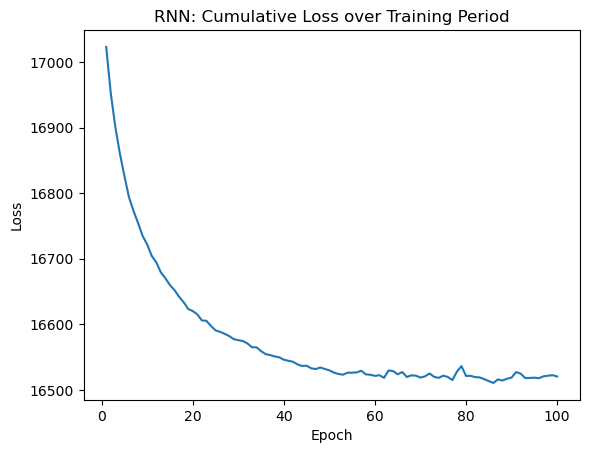

In [10]:
# plot loss over training period
rnn_training_loss = pd.read_csv('rnn_training_loss.csv')

plt.plot(rnn_training_loss['Epoch'], rnn_training_loss['Loss'])
plt.title('RNN: Cumulative Loss over Training Period')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
# create a 100-note melody and write it to a file
generated = rnn.generate_melody(max_notes=100)
write_melody(generated, 'rnn_melody.mid')

### Transformer

In [12]:
# define necessary constants
NGRAM = 10

In [13]:
# extract notes and rythyms from raw melodies (does not differentiate by octave)
melodies = []
for melody in raw_melodies:
    melodies.append(process_track(melody['track'], melody['bpm'], normalize_octaves=True))
    
# tokenizes the melodies (glues notes and rhythms together)
tokenized = tokenize_melodies(melodies, NGRAM, glue=True)

# encode melodies
transformer_encoder = note_encoder()
transformer_encoder.fit(processed_melodies)
encoded_melodies = transformer_encoder.transform(processed_melodies)

# filter melody length to be at least as long as NGRAM + 2
encoded_melodies = [melody for melody in encoded_melodies if len(melody) > NGRAM + 1]

# create custom-defined dataset
melody_dataset = TransformersDataset(encoded_melodies, NGRAM)

In [14]:
# create and train GPT2 model
gpt = GPT2(melody_dataset, transformer_encoder)
#gpt.train() # will take around 2 hours (Mac M2)
gpt = load_data('gpt_model.pkl')   # loads pre-trained model (to avoid having to go through training again)

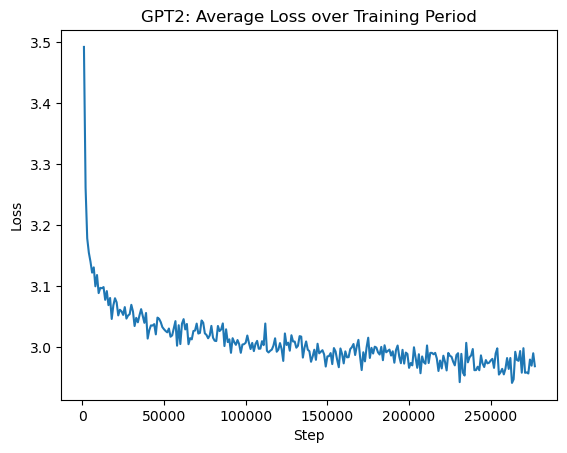

In [15]:
# plot loss over training period
gpt_training_loss = pd.read_csv('gpt_training_loss.csv')

plt.plot(gpt_training_loss['Step'], gpt_training_loss['Loss'])
plt.title('GPT2: Average Loss over Training Period')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [16]:
# create a 100-note melody and write it to a file
generated = gpt.generate_melody(100)
write_melody(generated, 'transformers_melody.mid', octaves=False)

## Generated Melodies
Using the MIDI files generated above, I converted each to an MP3 file, which I was able to embed in this notebook. The results of each model's melody generation is included below. 

In [17]:
print('N-Gram-Generated Melody:')
ipd.Audio('ngram_melody.mp3')

N-Gram-Generated Melody:


In [18]:
print('RNN-Generated Melody:')
ipd.Audio('rnn_melody.mp3')

RNN-Generated Melody:


In [19]:
print('Transformer-Generated Melody:')
ipd.Audio('transformers_melody.mp3')

Transformer-Generated Melody:


## Results
Which model performed the best is primarily subjective, but I did want to try to objectively measure each model's performance in some way. To do this, I generated 100 different melodies of 100 notes each from each model to try to see if the percentage of the notes and rhythms generated are proportional to the amounts seen in the training data. The results of this analysis are shown below.  

### Analyzing Training Data

I had to handicap the N-Gram model slightly and the Transformer model significantly to get them to predict valid melodies. While I included the same safeguards in the RNN model, I found that they were unnecessary. 

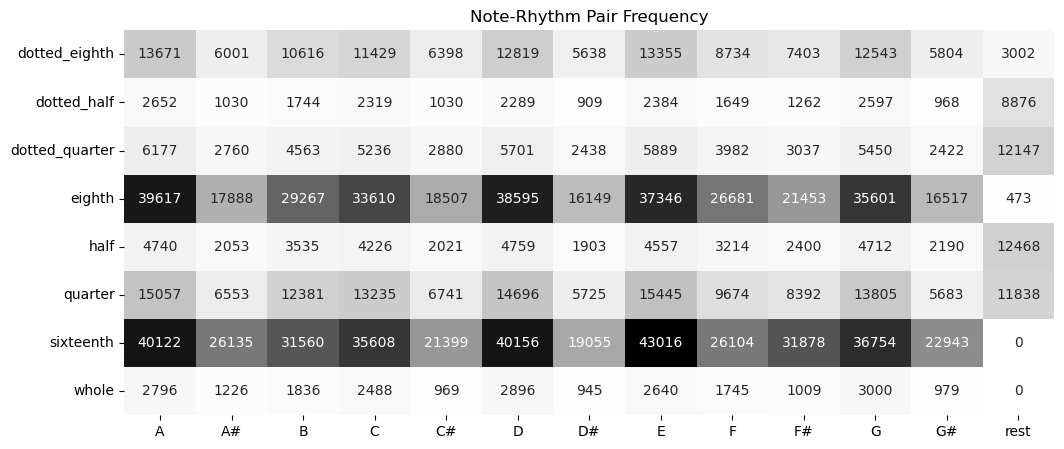

In [20]:
# extract notes and rythyms from raw melodies (does not differentiate by octave)
melodies = []
for melody in raw_melodies:
    melodies.append(process_track(melody['track'], melody['bpm'], normalize_octaves=True))
    
# tokenizes the melodies (glues notes and rhythms together)
tokenized = tokenize_melodies(melodies, 5, glue=True)

# pairs off notes and rhythms
notes = []
for melody in tokenized:
    notes += [item.split('-') for item in melody]

# counts how many times each pairing happens
notes_df = pd.DataFrame(notes, columns=['Note', 'Rhythm'])
counts = notes_df.groupby(['Note', 'Rhythm']).size().unstack(fill_value=0)

# plots a heatmap of most-frequent pairing
plt.figure(figsize=(12, 5))
sns.heatmap(counts.T, annot=True, fmt="d", cmap="Greys", cbar=False)
plt.title("Note-Rhythm Pair Frequency")
plt.xlabel("")
plt.ylabel("")
plt.show()

### Analyzing N-Gram Data

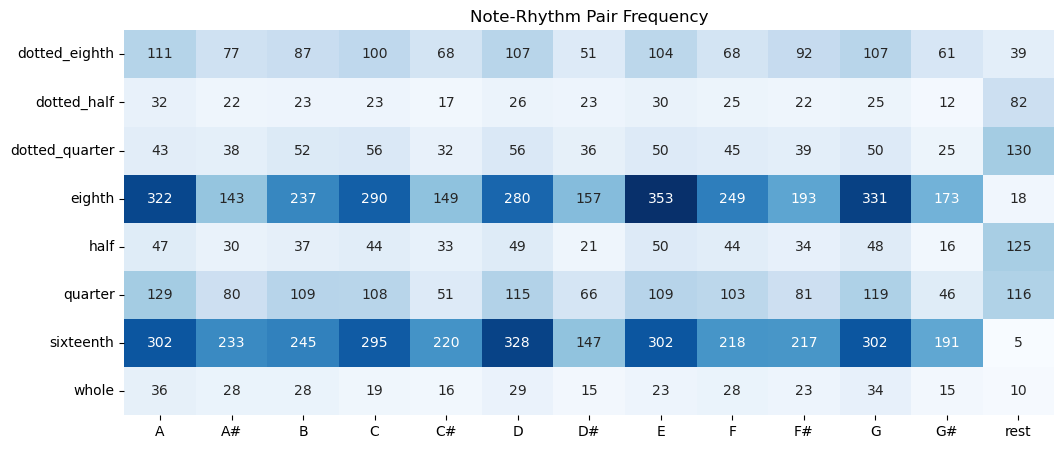

In [21]:
# generate 100 different melodies using the n-gram model
ngram_generations = []
for i in range(100):
    ngram_generations += ngram_model.generate_melody(max_notes=100)

# pairs off notes and rhythms
notes = [(ngram_generations[i], ngram_generations[i+1]) for i in range(0, len(ngram_generations), 2)]

# counts how many times each pairing happens
notes_df = pd.DataFrame(notes, columns=['Note', 'Rhythm'])
counts = notes_df.groupby(['Note', 'Rhythm']).size().unstack(fill_value=0)

# plots a heatmap of most-frequent pairing
plt.figure(figsize=(12, 5))
sns.heatmap(counts.T, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Note-Rhythm Pair Frequency")
plt.xlabel("")
plt.ylabel("")
plt.show()

### Analyzing RNN Data
For the purpose of this exercise, I did normalize by octaves after the generation. That being said, it is worth noting that the generation itself did not normalize by octaves, unlike the other modeling approaches. 

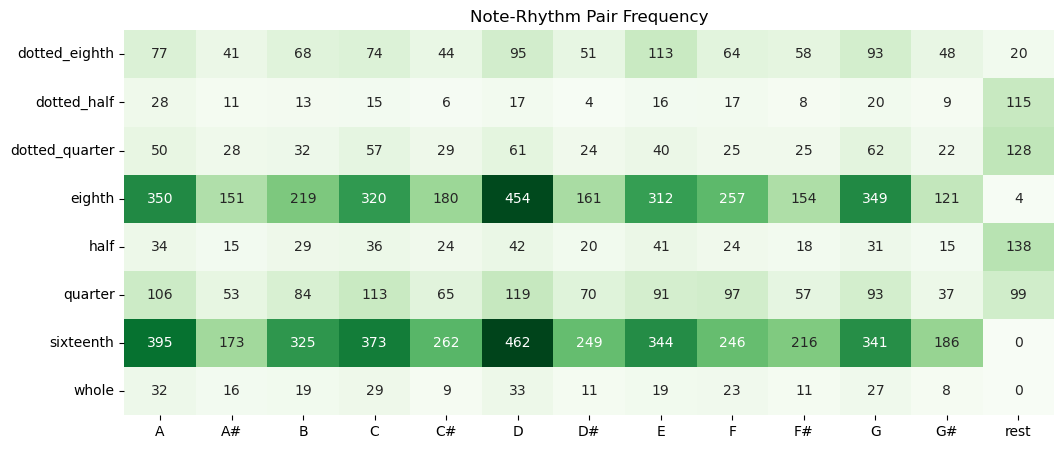

In [22]:
# generate 100 different melodies using the RNN model
raw_rnn_generations = []
for i in range(100):
    raw_rnn_generations += rnn.generate_melody(max_notes=100)

# process the rnn outputs (add in rests, convert numeric note values to letter names)
rnn_generations = []
for token in raw_rnn_generations:
    if token == '128':
        rnn_generations += ['rest']
    elif token not in RHYTHM_LABELS:
        rnn_generations += [NOTE_LABELS[int(token) % 12]]
    else:
        rnn_generations += [token]

# pairs off notes and rhythms
notes = [(rnn_generations[i], rnn_generations[i+1]) for i in range(0, len(rnn_generations), 2)]

# counts how many times each pairing happens
notes_df = pd.DataFrame(notes, columns=['Note', 'Rhythm'])
counts = notes_df.groupby(['Note', 'Rhythm']).size().unstack(fill_value=0)

# plots a heatmap of most-frequent pairing
plt.figure(figsize=(12, 5))
sns.heatmap(counts.T, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Note-Rhythm Pair Frequency")
plt.xlabel("")
plt.ylabel("")
plt.show()

### Analyzing Transformer Data

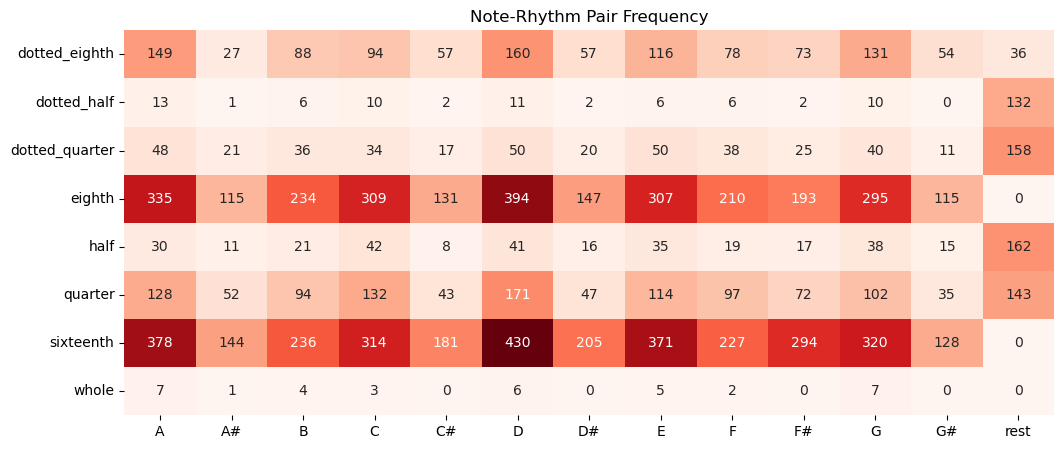

In [23]:
# generate 100 different melodies using the transformers model
gpt_generations = []
for i in range(100):
    gpt_generations += gpt.generate_melody(max_notes=100)

# pairs off notes and rhythms
notes = [(gpt_generations[i], gpt_generations[i+1]) for i in range(0, len(gpt_generations), 2)]

# counts how many times each pairing happens
notes_df = pd.DataFrame(notes, columns=['Note', 'Rhythm'])
counts = notes_df.groupby(['Note', 'Rhythm']).size().unstack(fill_value=0)

# plots a heatmap of most-frequent pairing
plt.figure(figsize=(12, 5))
sns.heatmap(counts.T, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.title("Note-Rhythm Pair Frequency")
plt.xlabel("")
plt.ylabel("")
plt.show()

## Conclusions
As shown above, the models all seem to predict notes and rhythms with approximately the same frequency as the training data. Eighth and sixteenth notes are the two most frequent rhythms across all model types, and A, D, and E notes are the most frequent pitches. These match the note/rhythm distributions seen in the training data, which would suggest that the models appear to be working fairly well. This means that the key differences between the models likely comes from how they sequence the different notes, which is much harder to objectively evaluate. 

In terms of the subjective evaluation of these models, I created several melodies from each model and showed them to a few friends, asking them to rank them by two factors: cohesiveness and engagement. For cohesiveness, I was looking for how much the melody stays within a consistent key signature and a consistent time signature. Do any of the notes sound out of place within the context of the rest of the melody? For engagement, I was interested in how creative the melody is. Are the notes and rhythms varied in an interesting way?

Using these parameters, I found that public opinion indicated that the RNN and transformer models significantly outperformed the n-gram model. The n-gram-generated melodies usually sounded just like a random collection of notes  and there was very little cohesiveness or engagement from any of the melodies. For the RNN and transformer models, the feedback was much more positive, though people were generally mixed between the two. Personally, I found that the RNN-generated melody was the most engaging, while the tranformer-generated melody was the most cohesive, but others disagreed. Ultimately, whichever model is the "best" essentially comes down to personal preference and what parameters the listener prioritizes over others. 